In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Definição das classes

In [2]:
class Acao:
    def __init__(self,valor,qtde,label=''):
        self.valor = valor
        self.qtde  = qtde
        self.label = label

    def payoff(self,valor_atual):
        return self.qtde*(valor_atual - self.valor)

    def plot_payoff(self,x_linspace=None,figsize=(12,6),ax=None,decomposing=False):
        if not x_linspace: x_linspace = (0,2*self.valor,1000)
        return Utils.plot_payoff(self,x_linspace,title_prefix='Ação',figsize=figsize,ax=ax,
                                 decompose=False,decomposing=decomposing)

class Opcao():
    def __init__(self,oper,qtde,premio,strike,label=''):
        self.oper    = oper
        self.premio  = premio
        self.strike  = strike
        self.qtde    = int(qtde)
        
        if label:
            self.label = label
        else:
            self.label = f'(strike: {self.strike})'
        
        if self.oper[0].lower() == 'v':
            self.long_short = 'Short'
        else:
            self.long_short = 'Long'

    def plot_payoff(self,x_linspace=None,figsize=(12,6),ax=None,decomposing=False):
        if not x_linspace: x_linspace = (0,2*self.strike,1000)
        return Utils.plot_payoff(self,x_linspace,title_prefix=self.long_short + self.prefix ,figsize=figsize,ax=ax,
                               decompose=False,decomposing=decomposing)

#call opção de VENDA
class Call(Opcao):
    def __init__(self,oper,qtde,premio,strike,label=''):
        self.prefix = ' Call'
        super(Call, self).__init__(oper,qtde,premio,strike,label)
        

    def payoff(self,valor_atual):
        
        #Se comprou a CALL
        if self.oper[0].lower() == 'c':
            #PAGA o prêmio
            #tem o DIREITO de COMPRAR o ativo pelo stike e vender ele pelo valor de mercado
            #favorável quando o mercado SOBE
            favoravel = (valor_atual - self.strike) > 0
            
            #resultado unitário
            #ao fazer a compra da CALL, já paga o prêmio.
            #se o mercado SUBIR, RECEBE a diferença entre o valor de mercado e do strike
            resultado = (valor_atual - self.strike - self.premio) if favoravel else (-self.premio)
            return self.qtde*resultado
        
        #Se vendeu a CALL
        elif self.oper[0].lower() == 'v':
            #RECEBE o prêmio
            #Caso seja exercido, tem a OBRIGAÇÃO de VENDER o ativo pelo stike
            #e pode comprar ele pelo valor de mercado (se n tiver o ativo)
            #favorável quando o mercado CAI
            favoravel = (self.strike - valor_atual) >= 0

            #resultado unitário
            #ao fazer a venda da CALL, já recebe o prêmio.
            #se o mercado CAIR, PAGA a diferença entre o strike e o valor de mercado
            resultado = (+self.premio) if favoravel else (self.strike - valor_atual + self.premio)
            return self.qtde*resultado


#put opção de Venda
class Put(Opcao):
    def __init__(self,oper,qtde,premio,strike,label=''):
        self.prefix = ' Put'
        super(Put, self).__init__(oper,qtde,premio,strike,label)
        

    def payoff(self,valor_atual):
        #Se comprou a PUT
        if self.oper[0].lower() == 'c':
            #PAGA o prêmio
            #tem o DIREITO de VENDER o ativo pelo stike e comprar ele pelo valor de mercado
            #favorável quando o mercado CAI
            favoravel = (self.strike - valor_atual) > 0
            
            #resultado unitário
            #ao fazer a compra da PUT, já paga prêmio.
            #se o mercado CAIR, RECEBE a diferença entre o strike e o valor de mercado
            resultado = (self.strike - valor_atual - self.premio) if favoravel else (-self.premio)
            
            return self.qtde*resultado
        
        #Se vendeu a PUT
        elif self.oper[0].lower() == 'v':
            #RECEBE o prêmio
            #Caso seja exercido, tem a OBRIGAÇÃO de COMPRAR o ativo pelo stike
            #e pode vender ele pelo valor de mercado (ou manter na carteira)
            #favorável quando o mercado SOBE
            favoravel = (valor_atual - self.strike) >= 0
            
            #resultado unitário
            #ao fazer a venda da PUT, recebe o prêmio.
            #se o mercado SUBIR, PAGA a diferença entre o valor de mercado e o strike
            resultado = (+self.premio) if favoravel else (valor_atual - self.strike + self.premio)
            
            return self.qtde*resultado

class Estrategia:

    def __init__(self,ativos,label=''):
        self.ativos = ativos
        self.label  = label

    def payoff(self,valor_atual):
        self.resultado = 0
        for ativo in self.ativos:
            self.resultado += ativo.payoff(valor_atual=valor_atual)
        return self.resultado
    
    def plot_payoff(self,x_linspace,decompose=False,figsize=(12,6),ax=None):
        return Utils.plot_payoff(self,x_linspace,title_prefix='Estratégia',decompose=decompose,figsize=figsize,ax=ax)

class Utils:
    @staticmethod
    def plot_payoff(investimento,x_linspace,title_prefix,decompose=False,figsize=(12,6),ax=None,decomposing=False):
            x = np.linspace(*x_linspace)
            payoff_vector = np.vectorize(investimento.payoff)
            y = payoff_vector(x)

            if not ax:
                fig,ax = plt.subplots(1,1,figsize=figsize)
            
            if not decomposing:
                sns.lineplot(x=x,y=y,ax=ax,label=f'{title_prefix} {investimento.label}')
                
                title_and_labels(ax=ax, title = f'{title_prefix}: {investimento.label}')
                ax.axhline(y = 0, color = 'gray', linestyle = 'dashed')
                ax.fill_between(x, y,where = y>=0,color='green', alpha=0.2)
                ax.fill_between(x, y,where = y<=0,color='red', alpha=0.2)
            else:                
                sns.lineplot(x=x,y=y,ax=ax,label=f'{title_prefix} {investimento.label}',alpha=.3)
            
            if decompose:
                ax.legend()
                for ativo in investimento.ativos:
                    ativo.plot_payoff(x_linspace,ax=ax,decomposing=True)
                    
            return ax
            

In [3]:
def title_and_labels(ax, title, xlabel='Valor de mercado da ação', ylabel='Payoff', fontsize=15, color='#337',rotation=0):
    ax.set_title(title, fontsize=fontsize, fontweight='normal', color=color)  
    ax.set_xlabel(xlabel, fontsize=fontsize-2, fontweight='normal', color=color)
    ax.set_ylabel(ylabel, fontsize=fontsize-2, fontweight='normal', color=color)  
    ax.tick_params(axis='both', colors = color)
    plt.tick_params(axis='x', rotation=rotation)

#title_and_labels(
#    ax       = ax,
#    title    = 'Titulo',
#    xlabel   = 'Xlabel',
#    ylabel   = 'Ylabel',
#    fontsize = 18,
#    color    = 'b', 
#    rotation = 33,
#);

# Exemplos

## Exemplo 1: Venda de Call (obrigação de vender)

Venda de 100 calls por R$1,50 e valor de exercício (strike) igual a 20:

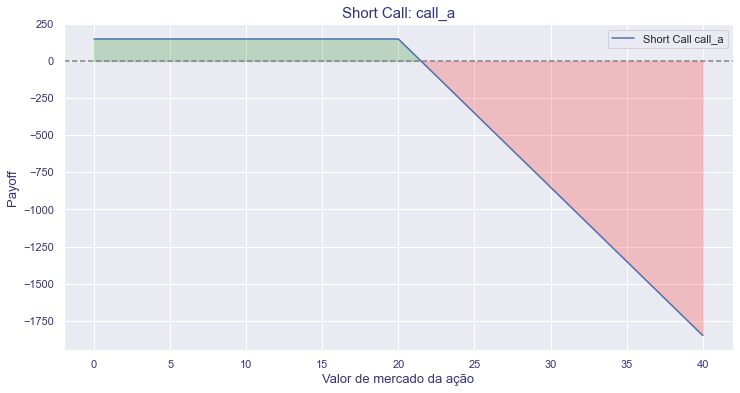

In [4]:
call_a = Call(oper='venda', qtde=100, premio=1.5, strike=20, label='call_a')
call_a.plot_payoff();

### Situação 1:
*Se o valor de mercado do ativo alvo ficar em um preço igual ou inferior a 20,  
NÃO HÁ exercício e o vendedor fica com o prêmio (é mais barato comprar o ativo no valor de mercado)
- Resultado = (100 * 1.50) = 150

In [5]:
call_a.payoff(valor_atual=18)

150.0

In [6]:
call_a.payoff(valor_atual=20)

150.0

### Situação 2:
*Se o valor de mercado do ativo alvo ficar em um preço superior a 20,  
HÁ exercício e o vendedor fica com o prêmio (100 * 1.50) mas é obrigado a vender a ação pelo valor do strike (baixo) e, se não tiver o ativo para vender, tem que comprar pelo valor de mercado (alto)

Ex: Valor de mercado do ativo no dia do exercício (valor_atual) = 24
- Resultado = 100 * (20-24+1.5) = -250

In [7]:
call_a.payoff(valor_atual=24)

-250.0

In [8]:
call_a.payoff(valor_atual=28)

-650.0

In [9]:
#obs, para o valor de 21, por exemplo, a perda com o gasto do exercício não é maior que o prêmio,
#portanto o resultado ainda é positivo
call_a.payoff(valor_atual=21)

50.0

---

## Exemplo 2: Compra de Call (direito de comprar)

Compra de 100 calls por R$1,70 e valor de exercício (strike) igual a 15:

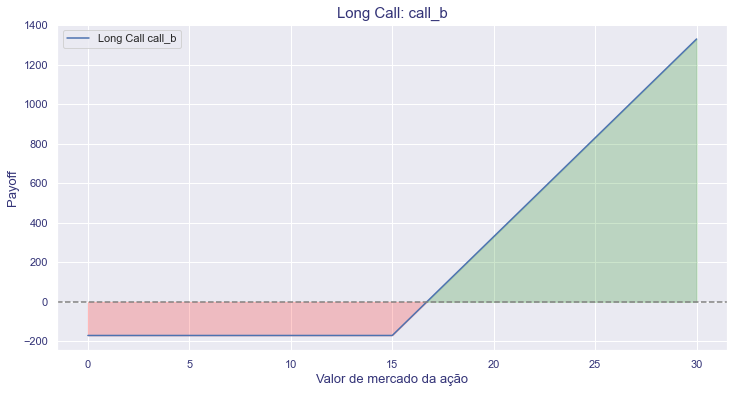

In [10]:
call_b = Call(oper='compra', qtde=100, premio=1.7, strike=15, label='call_b')
call_b.plot_payoff();

### Situação 1:

Se o valor de mercado do ativo alvo ficar em um preço igual ou inferior a 15,
NÃO HÁ vantagem em exercer o direito e o comprador simplesmente 'perde' o premio pago

Resultado = (100*-1.70) = -170

In [11]:
call_b.payoff(valor_atual=12)

-170.0

In [12]:
call_b.payoff(valor_atual=15)

-170.0

### Situação 2:

Se o valor de mercado do ativo alvo ficar em um preço superior a 15,
HÁ vantagem em exercer o direito e o comprador paga com o prêmio (100 * 1.20) e pode comprar a ação pelo valor do strike (baixo) e, se desejar, vender o ativo pelo valor de mercado (alto)

Ex: Valor de mercado do ativo no dia do exercício (valor_atual) = 18

Resultado = 100 * (18-15 -1.7) = +180

In [13]:
call_b.payoff(valor_atual=18)

130.0

In [14]:
call_b.payoff(valor_atual=20)

330.0

In [15]:
#obs, para o valor de 16, por exemplo, o ganho com o exercício não é maior que o prêmio,
#portanto o resultado é negativo
call_b.payoff(valor_atual=16)

-70.0

---

## Exemplo 3: Venda de Put (obrigação de comprar)

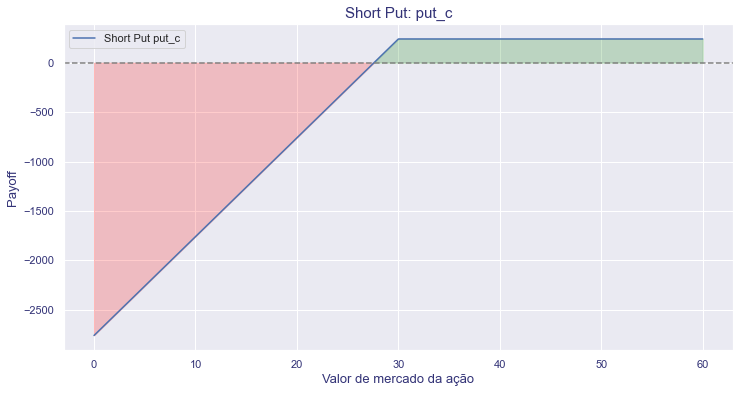

In [16]:
put_c = Put(oper='venda', qtde=100, premio=2.4, strike=30, label='put_c')
put_c.plot_payoff();

## Exemplo 4: Compra de Put (direito de vender)

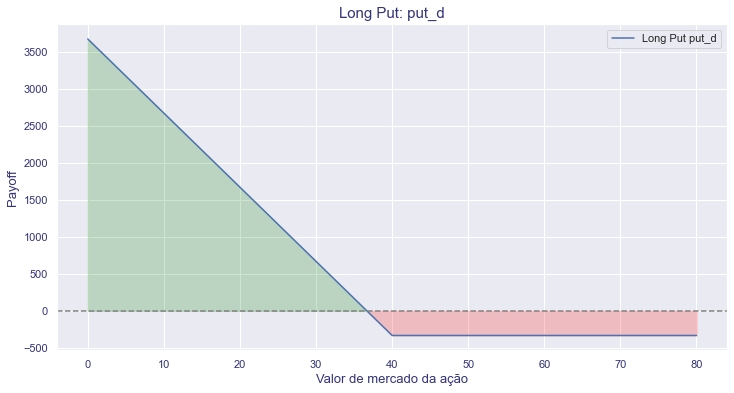

In [17]:
put_c = Put(oper='compra', qtde=100, premio=3.3, strike=40, label='put_d')
put_c.plot_payoff();

---

# Exercícios

##### Lista

1) Construa o payoff das seguintes estratégias:

1. **Lançar uma opção coberta**: É uma estratégia de hedge (minimizar riscos). Vende-se uma call e compra-se uma ação.
2. **Straddle comprador**: Estratégia de apostar na alta volatilidade. Compra-se uma call e uma put com o mesmo strike.
3. **Straddle vendedor**: Estratégia para vender volatilidade, acreditando que o mercado ficará estável em torno do strike, sem grandes oscilações. Vende-se uma call e uma put com o mesmo strike.
4. **Box Spread**: Utiliza-se call e put para obter um ganho fixo, qualquer que seja a cotação do ativo-objeto no vencimento. Seu resultado é sempre *K2 - K1*.
    - Compra call com strike K1
    - Vende call com strike K2 > K1
    - Vende put com strike K1
    - Compra put com strike K2
5. **Spread Butterfly**: Envolve posições em opções com 3 strikes diferentes. Leva um lucro se o preço ficar próximo de K2 e um pequeno prejuízo caso contrário. 
    - Compra uma call com K1 (strike baixo)
    - Compra uma call com K3 > K1 (strike alto)
    - Vende duas calls com K2, sendo K1 < K2 < K3 (strike próximo do spot)


2) Qual a diferença entre o straddle vendedor e o butterfly?


Chamadas das classes (para copiar e colar)
- call = Call(oper=,qtde=,premio=,strike=)
- put = Put(oper=,qtde=,premio=,strike=)
- acao = Acao(valor=)

## Lançar uma opção coberta
É uma estratégia de hedge (minimizar riscos). Vende-se uma call e compra-se uma ação.

In [18]:
estrategia =[
    Call(oper='venda',qtde=100,premio=1.73,strike=29.26,label='PETRA323'),
    Acao(valor=29.36,qtde=100,label='PETR4')
]

opcao_coberta = Estrategia(estrategia,label='Venda Coberta de Call')

In [19]:
for valor_atual in [0,17,18,19,20,30]:
    print('valor atual:',valor_atual,'payoff:',opcao_coberta.payoff(valor_atual))

valor atual: 0 payoff: -2763.0
valor atual: 17 payoff: -1063.0
valor atual: 18 payoff: -963.0
valor atual: 19 payoff: -863.0
valor atual: 20 payoff: -763.0
valor atual: 30 payoff: 163.00000000000023


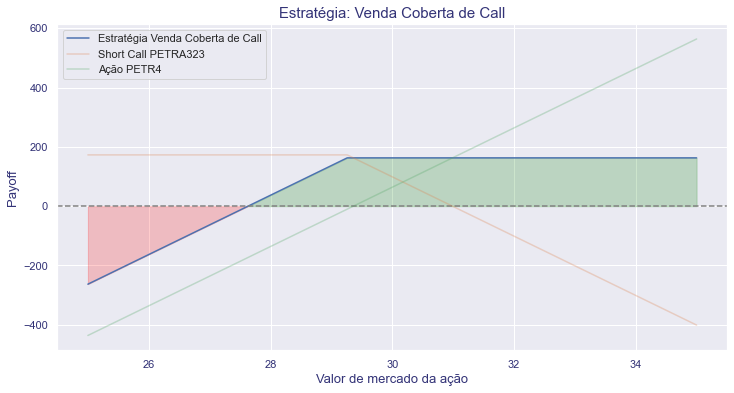

In [20]:
eixo_x = (25,35,1000)
opcao_coberta.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);

## Straddle comprador
Estratégia de apostar na alta volatilidade. Compra-se uma call e uma put com o mesmo strike.

In [21]:
estrategia =[
    Call(oper='compra',qtde=100,premio=1.73,strike=29.26,label='PETRA323'),
    Put(oper='compra',qtde=100,premio=1.31,strike=29.26,label='PETRM323'),
]

straddle_comprador = Estrategia(estrategia,label='Straddle comprador')

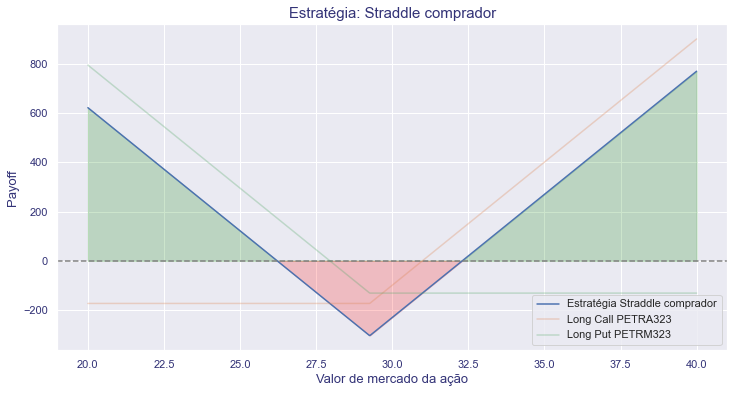

In [22]:
eixo_x = (20,40,1000)
straddle_comprador.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);

Obs: É possível fazer uma estratégia assimetrica

In [23]:
estrategia =[
    Call(oper='compra',qtde=100,premio=1.73,strike=29.26,label='PETRA323'),
    Put(oper='compra',qtde=200,premio=1.31,strike=29.26,label='PETRM323'),
]

straddle_comprador_a = Estrategia(estrategia,label='Straddle comprador')

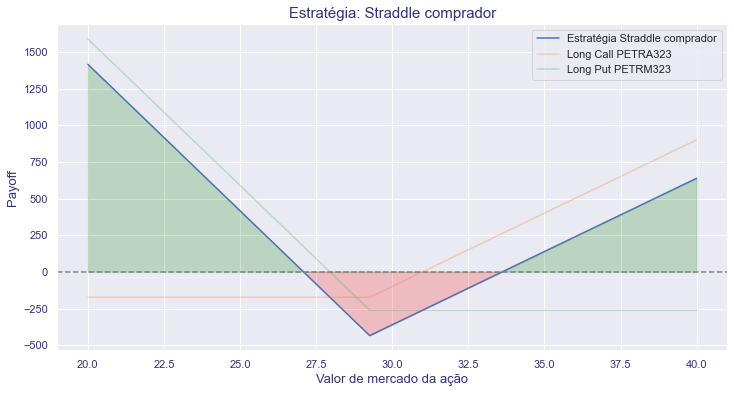

In [24]:
eixo_x = (20,40,1000)
straddle_comprador_a.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);

## Straddle vendedor
Estratégia para vender volatilidade, acreditando que o mercado ficará estável em torno do strike, sem grandes oscilações. Vende-se uma call e uma put com o mesmo strike.

In [36]:
estrategia =[
    Call(oper='venda',qtde=100,premio=1.73,strike=29.26,label='PETRA323'),
    Put(oper='venda',qtde=100,premio=1.31,strike=29.26,label='PETRM323'),
]

straddle_vendedor = Estrategia(estrategia,label='Straddle vendedor')

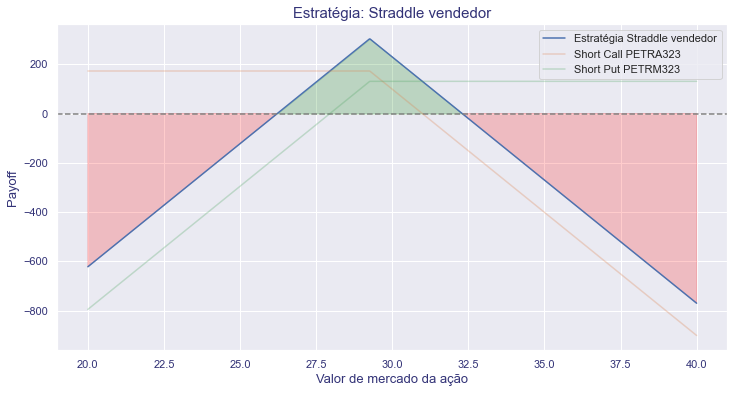

In [38]:
eixo_x = (20,40,1000)
straddle_vendedor.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);

## Box Spread
Utiliza-se call e put para obter um ganho fixo, qualquer que seja a cotação do ativo-objeto no vencimento. Seu resultado é sempre K2 - K1.

- Compra call com strike K1
- Vende call com strike K2 > K1
- Vende put com strike K1
- Compra put com strike K2

https://www.interest.com.vc/box-4-pontas/

In [27]:
estrategia =[
    Call(oper='compra',qtde=100,premio=2,strike=25),
    Call(oper='venda',qtde=100,premio=3,strike=26),
    Put(oper='compra',qtde=100,premio=2,strike=26),
    Put(oper='venda',qtde=100,premio=3,strike=25)
]
box_spread_ideal = Estrategia(estrategia,label='Box Spread Teórico')

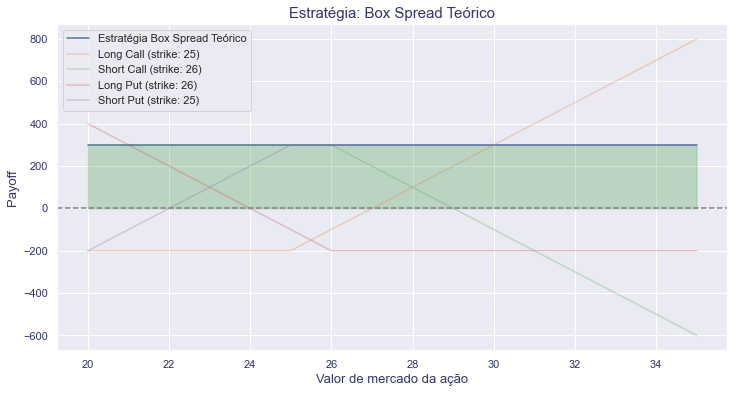

In [28]:
eixo_x = (20,35,1000)
box_spread_ideal.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);

Na prática não existe liquidez infinita das opções e, quanto mais out of the money você opera, mais dinheiro é perdido.

In [29]:
estrategia =[
    Call(oper='compra',qtde=100,premio=1.66,strike=29.01,label='PETRA321'),
    Call(oper='venda',qtde=100,premio=2.19,strike=28.01,label='PETRA286'),
    Put(oper='compra',qtde=100,premio=1.01,strike=28.01,label='PETRM286'),
    Put(oper='venda',qtde=100,premio=1.43,strike=29.01,label='PETRM321')
]
box_spread_real = Estrategia(estrategia,label='Box Spread Real')

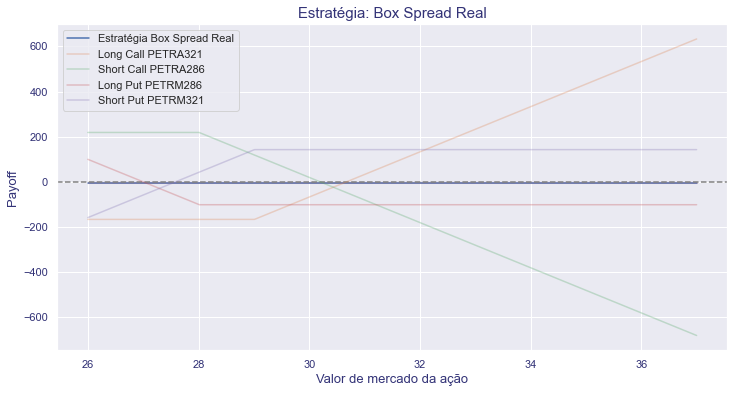

In [30]:
eixo_x = (26,37,1000)
box_spread_real.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);

## Spread Butterfly

Envolve posições em opções com 3 strikes diferentes.   
Leva um lucro se o preço ficar próximo de K2 e um pequeno prejuízo caso contrário.

- Compra uma call com K1 (strike baixo)
- Compra uma call com K3 > K1 (strike alto)
- Vende duas calls com K2, sendo K1 < K2 < K3 (strike próximo do spot)

https://www.infomoney.com.br/mercados/spread-butterfly-estrategia-pode-oferecer-bons-ganhos-em-momentos-de-calmaria/

In [31]:
estrategia =[
    Call(oper='compra',qtde=100,premio=2.25,strike=28.26,label='PETRA313'),
    Call(oper='compra',qtde=100,premio=1.21,strike=30.26,label='PETRA333'),
    Call(oper='venda',qtde=200,premio=1.72,strike=29.26,label='PETRA323'),
]
spread_butterfly = Estrategia(estrategia,label='Spread Butterfly')

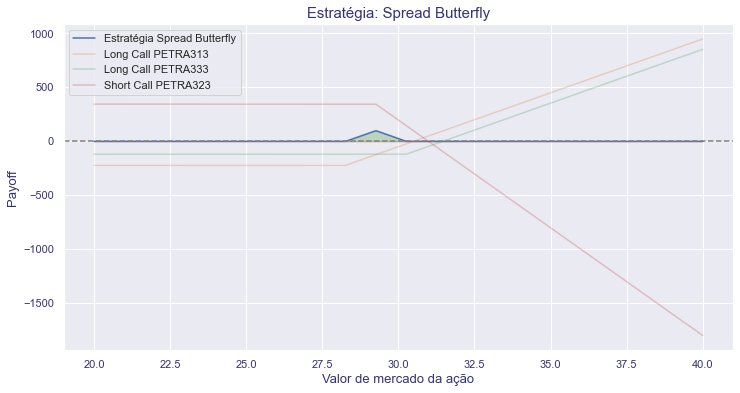

In [32]:
eixo_x = (20,40,2000)
spread_butterfly.plot_payoff(x_linspace=eixo_x,figsize=(12,6),decompose=True);


## Comparando Spread Butterfly com Straddle Vendedor

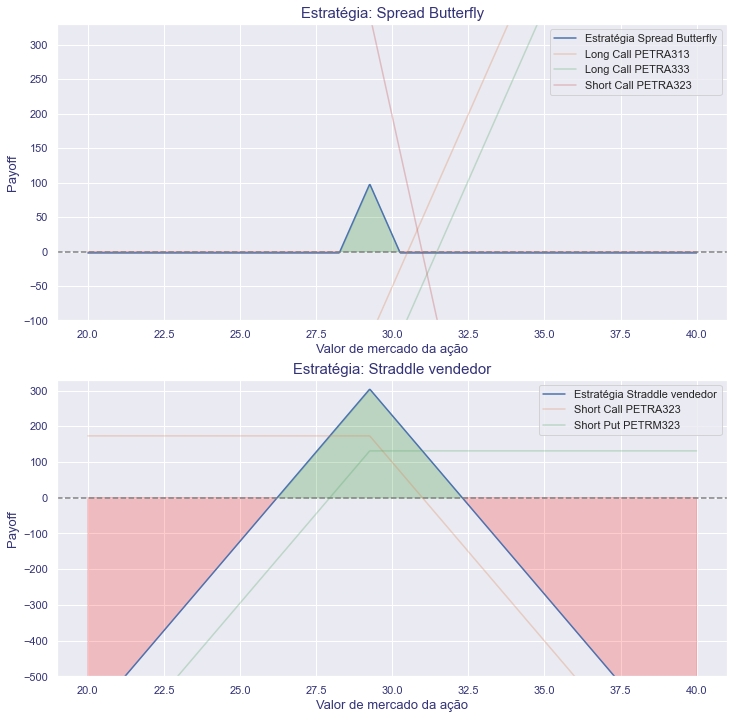

In [39]:
eixo_x = (20,40,1000)
fig,ax = plt.subplots(2,1,figsize=(12,12))
spread_butterfly.plot_payoff(x_linspace=eixo_x,decompose=True,ax=ax[0])
straddle_vendedor.plot_payoff(x_linspace=eixo_x,decompose=True,ax=ax[1])

ylim_0 = (-100, 330)
ylim_1 = (-500, 330)
ax[0].set(ylim=ylim_0,autoscale_on=False)
ax[1].set(ylim=ylim_1,autoscale_on=False);

A grosso modo, o straddle vendedor tem uma possibilidade de ganho mais alta, porém não existe um limite para as perdas da estratégia. Já o Spread Butterfly tem uma zona de ganho mais estreita e de menor amplitude, porém o valor máximo de perda é muito menor.

No straddle vendedor, se desejar aumentar a zona de ganho (no eixo x), terá que procurar opções cada vez mais OTM, o que fará a estratégia sofrer com o spread da falta de liquidez, já o Spread Butterfly é feito pela venda de uma PUT e uma CALL ATM, essa estratégia sofre muito menos com problemas com spread da liquidez.